In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score as sil_score, silhouette_samples as sil_samples
from sklearn.mixture import GaussianMixture
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import FastICA
from sklearn.neural_network import MLPClassifier
from time import clock

**Load Spam**

In [5]:
spam_df = pd.read_csv('spambase.csv', header=0)
spam_x = spam_df.drop('class', axis=1).copy().values
spam_y = spam_df['class'].copy().values
spam_x = StandardScaler().fit_transform(spam_x)
spam_x.shape

(4601, 57)

**Load Digits**

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
digits_x = StandardScaler().fit_transform(digits.data)
digits_y = digits.target
digits_x.shape

(1797, 64)

In [19]:
dims = [2,5,10,15,20,25,30,35,40,45,50,55,60,70]

In [20]:
spamIca = FastICA(random_state=5)
spamKurt = {}
for dim in dims:
    spamIca.set_params(n_components=dim)
    tmp = spamIca.fit_transform(spam_x)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    spamKurt[dim] = tmp.abs().mean()

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 57
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 57
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


In [21]:
digitsIca = FastICA(random_state=5)
digitsKurt = {}
for dim in dims:
    digitsIca.set_params(n_components=dim)
    tmp = digitsIca.fit_transform(digits_x)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    digitsKurt[dim] = tmp.abs().mean()

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 64
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increas

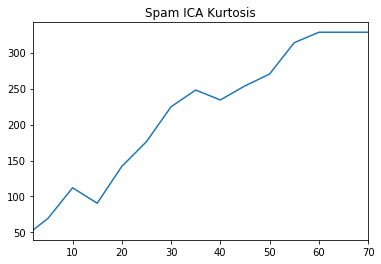

In [22]:
pd.Series(spamKurt).plot(title="Spam ICA Kurtosis")

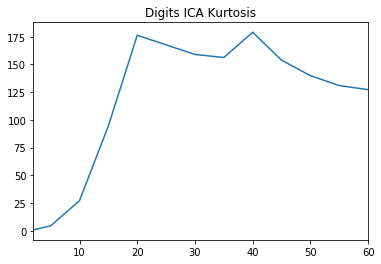

In [9]:
pd.Series(digitsKurt).plot(title="Digits ICA Kurtosis")

In [8]:
from helpers import cluster_acc
spam_ica = FastICA(random_state=5, n_components=60)
spam_x_red = spam_ica.fit_transform(spam_x)
digits_ica = FastICA(random_state=5, n_components=22)
digits_x_red = digits_ica.fit_transform(digits_x)
km = KMeans(random_state=5)
gmm = GaussianMixture(random_state=5)
clusters =  [2,5,10,15,20,25,30,35,40,50,70,80,90,100,115,130]
accSpam = {}
acc = defaultdict(lambda: defaultdict(dict))
SSE = defaultdict(dict)
ll = defaultdict(dict)
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(digits_x_red)
    gmm.fit(digits_x_red)
    acc[k]['digits']['kmeans'] = cluster_acc(digits_y, km.predict(digits_x_red))
    acc[k]['digits']['gmm'] = cluster_acc(digits_y, gmm.predict(digits_x_red))
    SSE[k]['digits'] = km.score(digits_x_red)
    ll[k]['digits'] = gmm.score(digits_x_red)
    km.fit(spam_x_red)
    gmm.fit(spam_x_red)
    acc[k]['spam']['kmeans'] = cluster_acc(spam_y, km.predict(spam_x_red))
    acc[k]['spam']['gmm'] = cluster_acc(spam_y, gmm.predict(spam_x_red))
    SSE[k]['spam'] = km.score(spam_x_red)
    ll[k]['spam'] = gmm.score(spam_x_red)    

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 57
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


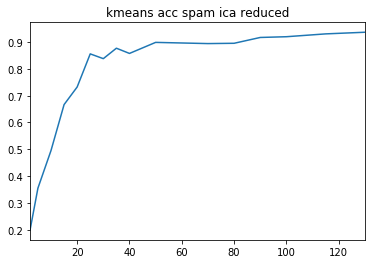

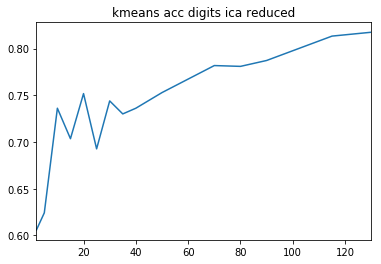

In [30]:
kmeansAccSpam = defaultdict(dict)
kmeansAccDigits = defaultdict(dict)
for k in acc:
    kmeansAccSpam[k] = acc[k]['digits']['kmeans']
    kmeansAccDigits[k] = acc[k]['spam']['kmeans']

pd.DataFrame.from_dict(kmeansAccSpam, orient='index', columns=['acc']).plot(title='kmeans acc spam ica reduced', legend=False)
pd.DataFrame.from_dict(kmeansAccDigits, orient='index', columns=['acc']).plot(title='kmeans acc digits ica reduced', legend=False)

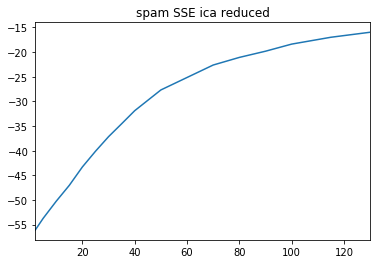

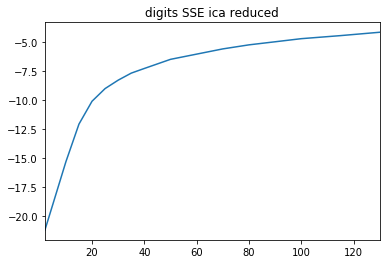

In [31]:
pd.DataFrame.from_dict(SSE, orient='index')['spam'].plot(title='spam SSE ica reduced')
plt.show()
pd.DataFrame.from_dict(SSE, orient='index')['digits'].plot(title='digits SSE ica reduced')

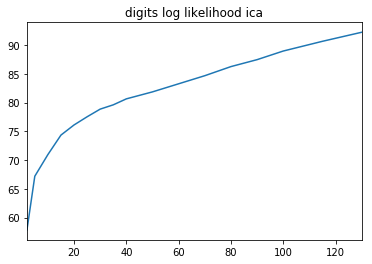

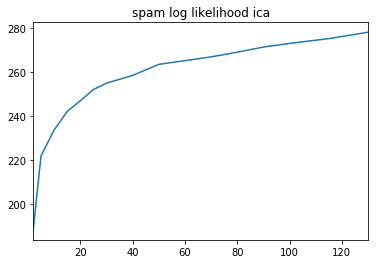

In [9]:
pd.DataFrame.from_dict(ll, orient='index')['digits'].plot(title='digits log likelihood ica')
plt.show()
pd.DataFrame.from_dict(ll, orient='index')['spam'].plot(title='spam log likelihood ica')

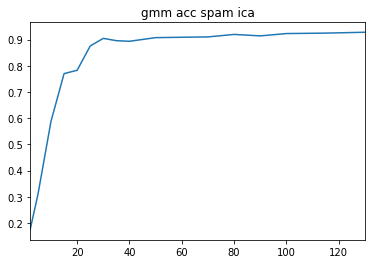

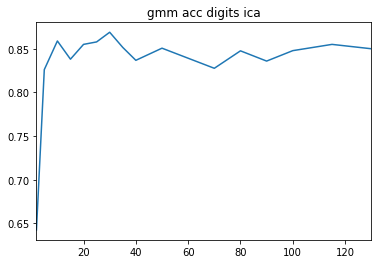

In [10]:
gmmAccSpam = defaultdict(dict)
gmmAccDigits = defaultdict(dict)
for k in acc:
    gmmAccSpam[k] = acc[k]['digits']['gmm']
    gmmAccDigits[k] = acc[k]['spam']['gmm']

pd.DataFrame.from_dict(gmmAccSpam, orient='index', columns=['acc']).plot(title='gmm acc spam ica', legend=False)
pd.DataFrame.from_dict(gmmAccDigits, orient='index', columns=['acc']).plot(title='gmm acc digits ica', legend=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/p

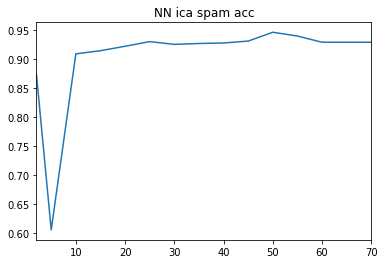

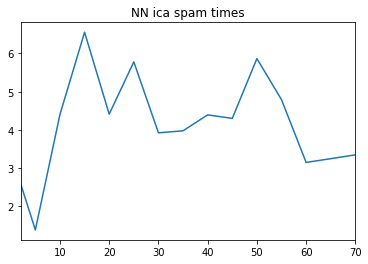

In [3]:
dims_times = {}
dims_acc = {}
dims = [2,5,10,15,20,25,30,35,40,45,50,55,60,70]
for d in dims:
    ica = FastICA(random_state=5, n_components=d)
    spam_red = ica.fit_transform(spam_x)
    mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5, hidden_layer_sizes=(spam_red.shape[1], 57, 57))
    st = clock()
    mlp.fit(spam_red, spam_y)
    dims_times[d] = clock() - st
    dims_acc[d] = mlp.score(spam_red, spam_y)

pd.DataFrame.from_dict(dims_acc, orient='index').plot(title='NN ica spam acc', legend=False)
pd.DataFrame.from_dict(dims_times, orient='index').plot(title='NN ica spam times', legend=False)